In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import pandas as pd
import numpy as np

import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
print(pd.__version__)

1.4.2


In [38]:
import pickle

infile = open("Preprocessed/mfcc_list_time-series_639450_10_60",'rb')
mfcc_list = pickle.load(infile)
infile.close()

In [87]:
df = pd.read_csv("Data/features_30_sec.csv")
df['labels'] = range(0, 1000)
mfcc_list = mfcc_list.merge(df, on="labels", how="left")

mfcc_list.head()


,mfcc,labels,filename_x,length_x,chroma_stft_mean_x,chroma_stft_var_x,rms_mean_x,rms_var_x,spectral_centroid_mean_x,spectral_centroid_var_x,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,"[[-242.4359893798828, 102.18486022949219, -9.9...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,"[[-185.00997924804688, 107.80894470214844, 9.4...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
2,"[[-187.95018005371094, 87.32178497314453, -25....",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
3,"[[-217.97210693359375, 93.81674194335938, 23.6...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
4,"[[-167.35015869140625, 129.44635009765625, -14...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues


In [88]:
# creating instance of labelencoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
mfcc_list['labels'] = le.fit_transform(mfcc_list.label.values)
mfcc_list.head()

,mfcc,labels,filename_x,length_x,chroma_stft_mean_x,chroma_stft_var_x,rms_mean_x,rms_var_x,spectral_centroid_mean_x,spectral_centroid_var_x,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,"[[-242.4359893798828, 102.18486022949219, -9.9...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,"[[-185.00997924804688, 107.80894470214844, 9.4...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
2,"[[-187.95018005371094, 87.32178497314453, -25....",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
3,"[[-217.97210693359375, 93.81674194335938, 23.6...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
4,"[[-167.35015869140625, 129.44635009765625, -14...",0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues


In [89]:
print(len(mfcc_list))

10000


In [124]:
#convert mfcc column to matrix
def mfcc_dict(df):
    
    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    
    for i in range(len(df)):
        data["mapping"].append(df.label.iloc[i])
        data["labels"].append(df.labels.iloc[i])
        data["mfcc"].append(df.mfcc.iloc[i])
        
    return data

In [125]:
def load_data(data):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z



In [126]:
def prepare_datasets(mfcc_list, test_size,validation_size):
    """Loads data and splits it into train, validation and test sets.
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    
    from sklearn.model_selection import train_test_split
    
    
    #load data
    data = mfcc_dict(mfcc_list)
    X, y, z = load_data(data)
    print(X.shape,y.shape,z.shape)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    from keras.utils.np_utils import to_categorical
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z

In [127]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(mfcc_list,0.25,0.2)

(10000, 125, 60) (10000,) (10000,)


In [128]:
print(y_test)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [129]:
def CNN2D(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [130]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [131]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = CNN2D(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 123, 58, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 29, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 62, 29, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 27, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 14, 32)       0         
 g2D)                                                            
                                                      

In [132]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 24s 123ms/step - loss: 0.1526 - accuracy: 0.9575 - val_loss: 11.3776 - val_accuracy: 0.0000e+00
Epoch 2/30
188/188 [==============================] - 23s 123ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 14.2210 - val_accuracy: 0.0000e+00
Epoch 3/30
188/188 [==============================] - 25s 131ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 15.8015 - val_accuracy: 0.0000e+00
Epoch 4/30
188/188 [==============================] - 26s 136ms/step - loss: 7.8536e-04 - accuracy: 1.0000 - val_loss: 16.7728 - val_accuracy: 0.0000e+00
Epoch 5/30
188/188 [==============================] - 30s 159ms/step - loss: 4.0241e-04 - accuracy: 1.0000 - val_loss: 17.4501 - val_accuracy: 0.0000e+00
Epoch 6/30
188/188 [==============================] - 30s 161ms/step - loss: 3.8318e-04 - accuracy: 1.0000 - val_loss: 18.1223 - val_accuracy: 0.0000e+00
Epoch 7/30
188/188 [==============================] - 27s 146ms/step - loss: 2.1246e-04 

In [133]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

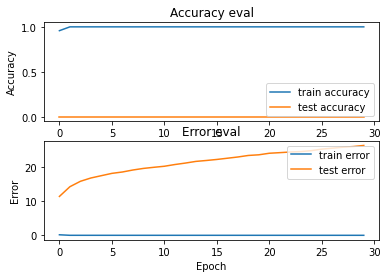

In [134]:
# plot accuracy/error for training and validation
plot_history(history)

In [135]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 2s - loss: 1.5471e-07 - accuracy: 1.0000 - 2s/epoch - 24ms/step

Test accuracy: 1.0


In [136]:
# pick a sample to predict from the test set
X_to_predict = X_test[151]
y_to_predict = y_test[151]

# predict sample
predict(model, X_to_predict, y_to_predict)

IndexError: arrays used as indices must be of integer (or boolean) type